<a href="https://colab.research.google.com/github/seun829/DataScience/blob/main/Unit5/SeunLee_U5proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Relating the Performance Rating of a Chess Opening to the Percentage of Games that End in a Draw

First I will import all required tools

In [16]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Introduction

During this project I will be comparing how the average performance rating of a player in a specific chess opening relates to the percentage of games that end in a draw.

I chose this because I am interested in the extent to which a higher average performance in a opening leads to more trials. As someone who enjoys playing chess, I would like to know the true implications of higher ELO(rating) and the trends that come with it.

Going into this, I expect a somewhat high correlation between these, but wouldn't be suprised if the correlation is weak.

# Scatterplot

First I will import my dataset

In [17]:
url_chess = "https://raw.githubusercontent.com/seun829/DataScience/refs/heads/main/high_elo_opening.csv"
chess_data = pd.read_csv(url_chess, dtype={'opening_name':'category'})

In [18]:
chess_data

,opening_name,side,num_games,ECO,last_played_date,perf_rating,avg_player,perc_player_win,perc_draw,pec_opponent_win,...,move2b,move3w,move3b,move4w,move4b,perc_white_win,perc_black_win,white_odds,white_wins,black_wins
0,"Alekhine Defense, Balogh Variation",white,692,B03,2018-06-22,2247,2225,40.8,24.3,35.0,...,Nd5,d4,d6,Bc4,NaN,40.8,35.0,1.165714,282.336,242.200
1,"Alekhine Defense, Brooklyn Variation",black,228,B02,2018-06-27,2145,2193,29.8,22.4,47.8,...,Ng8,NaN,NaN,NaN,NaN,47.8,29.8,1.604027,108.984,67.944
2,"Alekhine Defense, Exchange Variation",white,6485,B03,2018-07-06,2244,2194,40.8,27.7,31.5,...,Nd5,d4,d6,c4,Nb6,40.8,31.5,1.295238,2645.880,2042.775
3,"Alekhine Defense, Four Pawns Attack",white,881,B03,2018-06-20,2187,2130,39.7,23.2,37.1,...,Nd5,d4,d6,c4,Nb6,39.7,37.1,1.070081,349.757,326.851
4,"Alekhine Defense, Four Pawns Attack, Fianchett...",black,259,B03,2018-05-20,2122,2178,37.8,21.2,40.9,...,Nd5,d4,d6,c4,Nb6,40.9,37.8,1.082011,105.931,97.902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879,"Zukertort Opening, Sicilian Invitation",black,20045,A04,2018-07-09,2274,2293,31.4,33.9,34.7,...,NaN,NaN,NaN,NaN,NaN,34.7,31.4,1.105096,6955.615,6294.130
1880,"Zukertort Opening, Slav Invitation",black,463,A04,2018-07-05,2031,2025,27.0,26.1,46.9,...,NaN,NaN,NaN,NaN,NaN,46.9,27.0,1.737037,217.147,125.010
1881,"Zukertort Opening, Symmetrical Variation",black,15625,A04,2018-07-09,2235,2257,28.4,34.4,37.1,...,NaN,NaN,NaN,NaN,NaN,37.1,28.4,1.306338,5796.875,4437.500
1882,"Zukertort Opening, Tennison Gambit",white,139,A06,2018-05-19,1936,1976,36.7,19.4,43.9,...,NaN,NaN,NaN,NaN,NaN,36.7,43.9,0.835991,51.013,61.021


Now with my scatter plot, I will extract the correct collumns and go on from there.

Text(0, 0.5, 'Percentage of Games That Ended in a Draw')

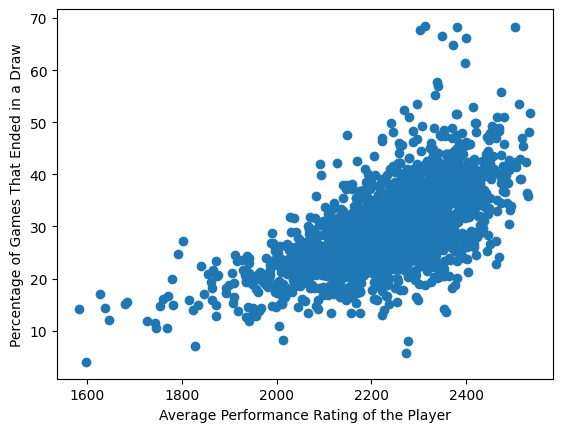

In [19]:
plt.scatter(chess_data['perf_rating'], chess_data['perc_draw'])
plt.xlabel("Average Performance Rating of the Player")
plt.ylabel("Percentage of Games That Ended in a Draw")

It seems like the values are pretty clustered around certain values depending on the performance rating of the player.

This indicates a correlation between the rating and the percentage of games that end in a draw.

# Straight Line Linear Regression Model

Now I will move on to my straight line linear regression to get a baseline of the correlation..

In [20]:
with pm.Model() as model_chess:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=25, sigma=5)
    β = pm.Normal("β", mu=0, sigma=0.01)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * chess_data.perf_rating)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 3)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=chess_data.perc_draw)

    #inference data object
    idata_chess = pm.sample(progressbar=False)


Text(0, 0.5, 'Percent of Games That Ended in a Draw')

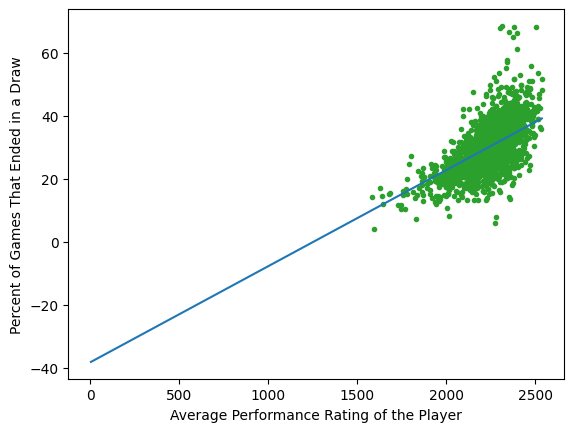

In [21]:
#grabs 100 posterior samples
posterior = az.extract(idata_chess, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(chess_data.perc_draw.min(), chess_data.perf_rating.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(chess_data.perf_rating, chess_data.perc_draw, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("Average Performance Rating of the Player")
ax.set_ylabel("Percent of Games That Ended in a Draw")

I think it's a pretty solid correlation. There are a few outliers, but generally as performance rating goes up so does the amount of drawn games.

/usr/local/lib/python3.12/dist-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (1887) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
        <Axes: title={'center': 'μ\n0'}>,
        <Axes: title={'center': 'μ\n1'}>],
       [<Axes: title={'center': 'μ\n2'}>,
        <Axes: title={'center': 'μ\n3'}>,
        <Axes: title={'center': 'μ\n4'}>,
        <Axes: title={'center': 'μ\n5'}>],
       [<Axes: title={'center': 'μ\n6'}>,
        <Axes: title={'center': 'μ\n7'}>,
        <Axes: title={'center': 'μ\n8'}>,
        <Axes: title={'center': 'μ\n9'}>],
       [<Axes: title={'center': 'μ\n10'}>,
        <Axes: title={'center': 'μ\n11'}>,
        <Axes: title={'center': 'μ\n12'}>,
        <Axes: title={'center': 'μ\n13'}>],
       [<Axes: title={'center': 'μ\n14'}>,
        <Axes: title={'center': 'μ\n15'}>,
        <Axes: title={'center': 'μ\n16'}>,
        <Axes: title={'center': 'μ\n17'}>],
       [<Axes: title={'center': 'μ\n18'}>,
        <Axes: title={'center': 'μ\n19'}>,
        <Axes: title={'center': 'μ\n20'}>,
        <Axes: title={'center': 

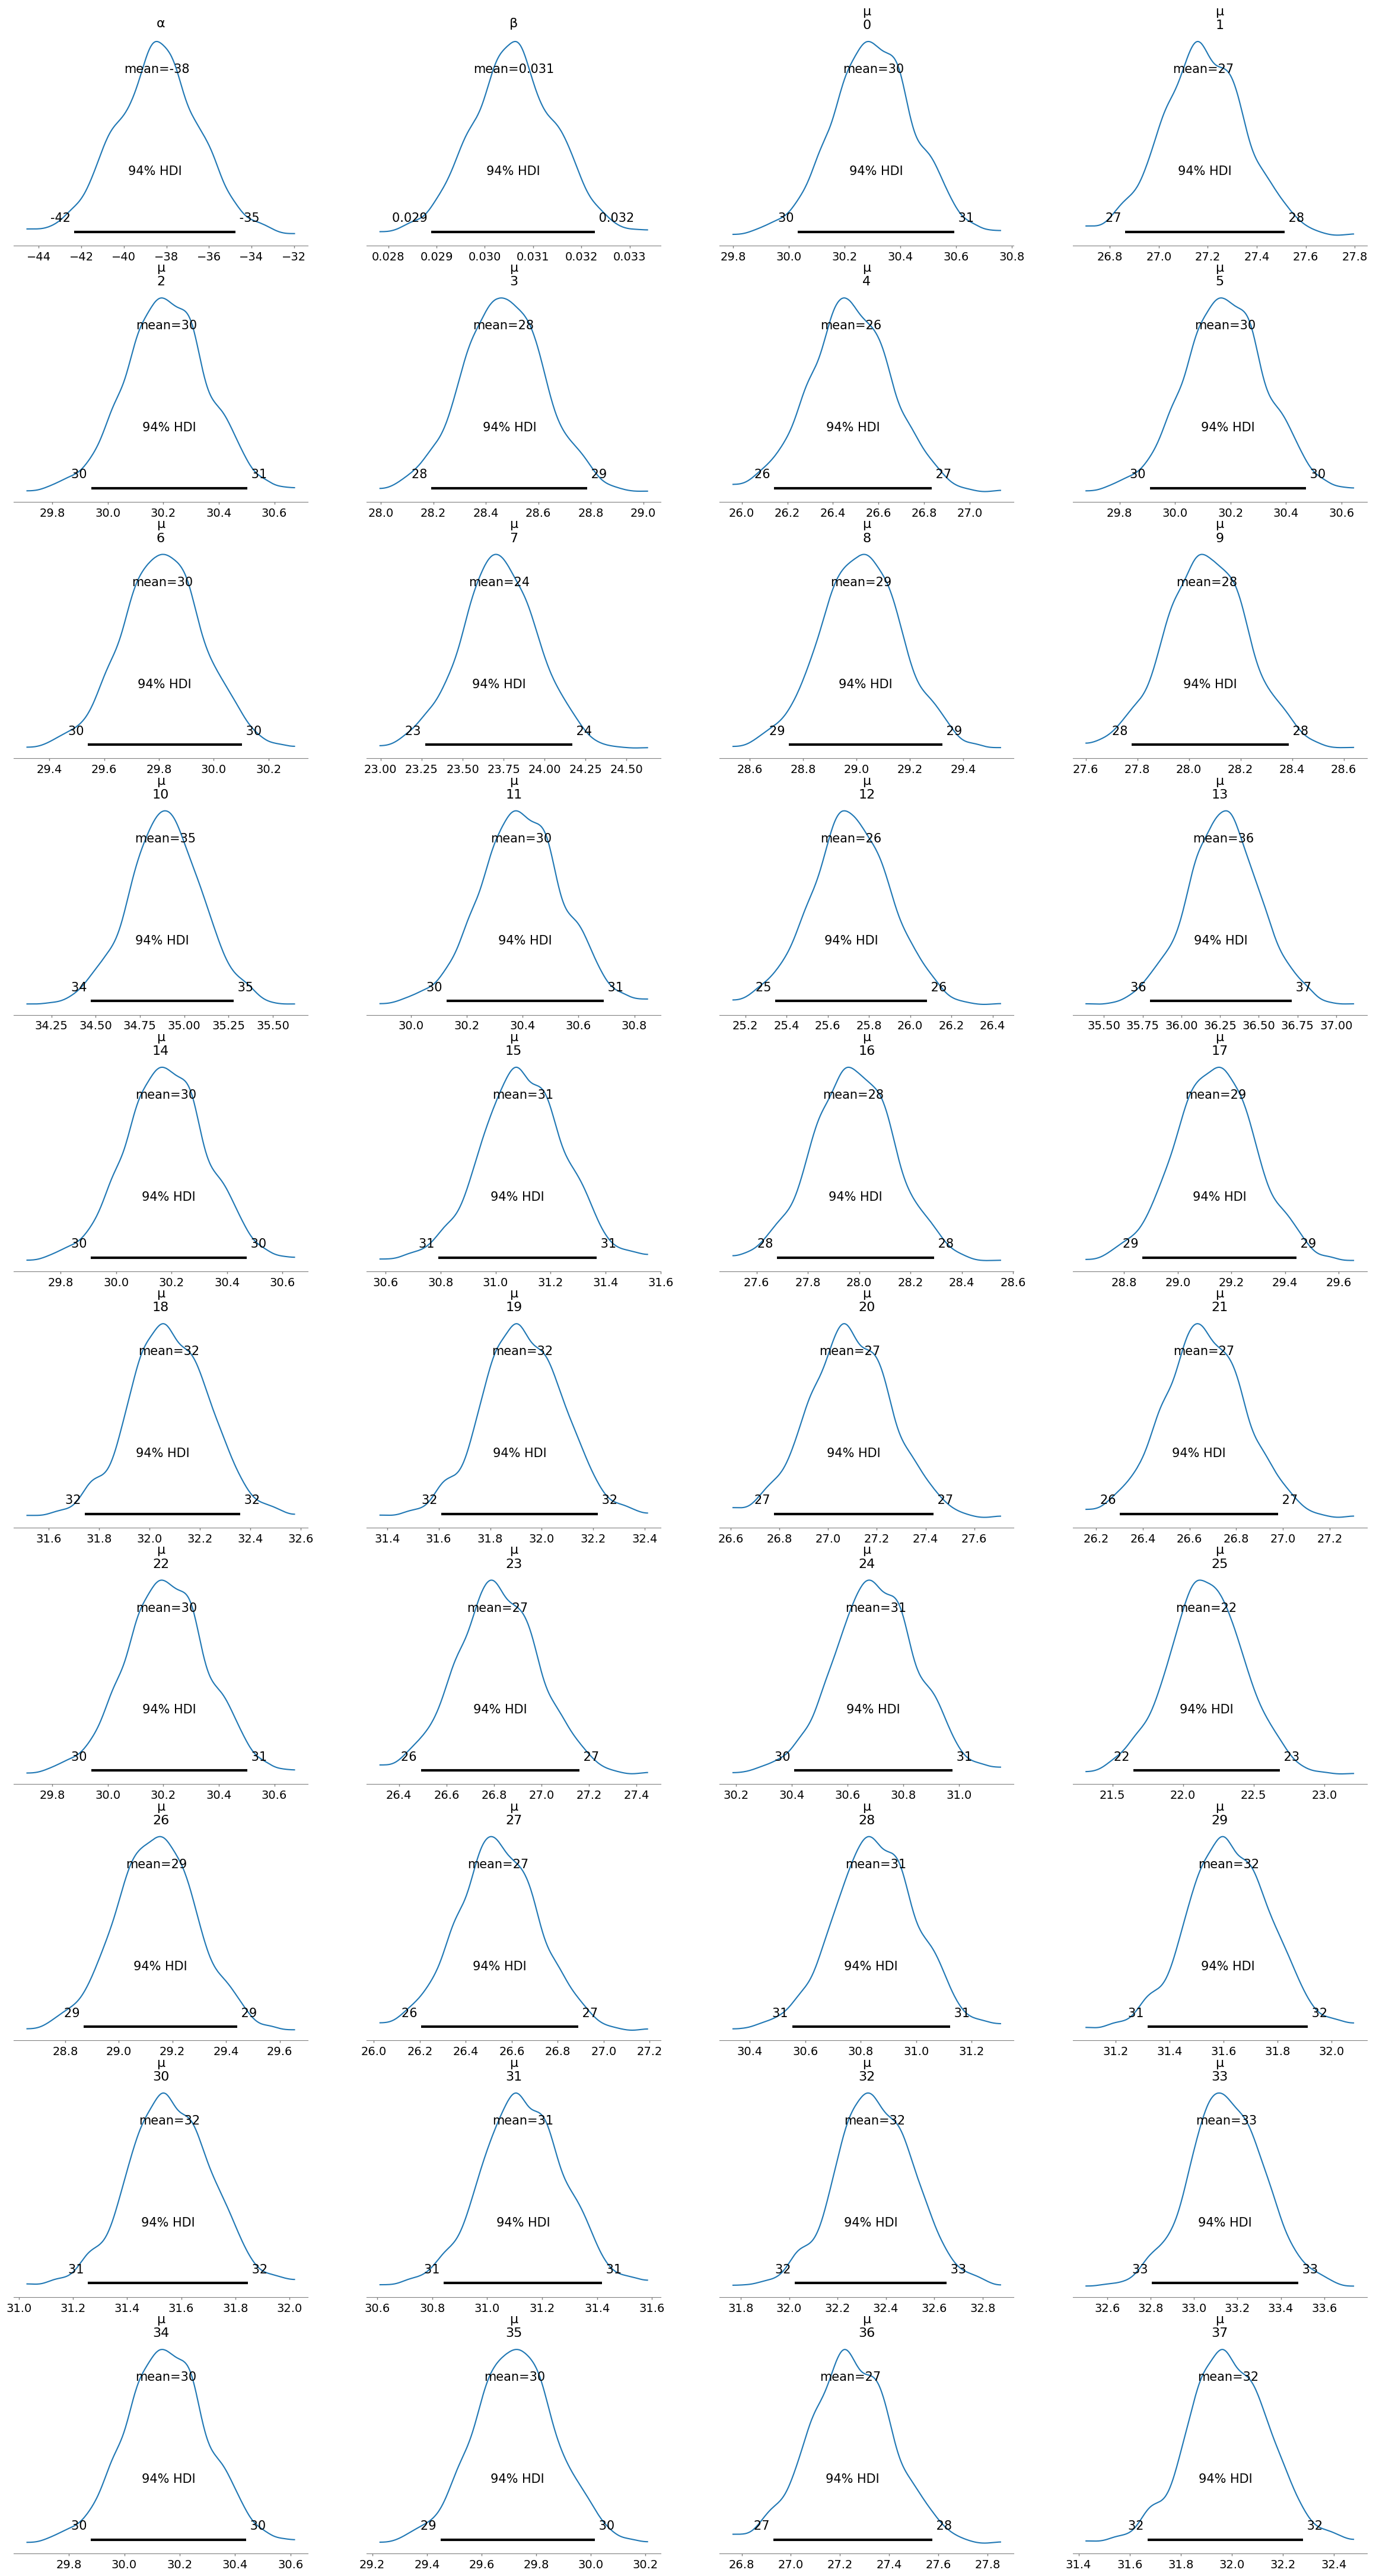

In [22]:
az.plot_posterior(idata_chess)

In [23]:
# posterior predictive check
pm.sample_posterior_predictive(idata_chess, model=model_chess,  extend_inferencedata=True, progressbar=False)

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

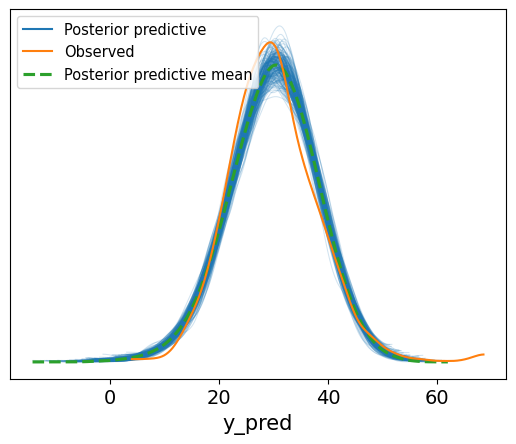

In [ ]:
az.plot_ppc(idata_chess, num_pp_samples=200, colors=['C0', 'C1', 'C2'])

I like the posterior, the model seems to represent the data very well.

# Generalized Linear Model

Now I will move on to my generalized model to have a more general idea of the correlation.

For this model I want to avoid using the previous prior for standard deviation because HalfCauchy allows for too many possibilities with the parameters, which is not ideal, according to google.

In [24]:
with pm.Model() as model_chess2:

    # priors for our mean line
    α = pm.Normal("α", mu=25.0, sigma=5.0)
    β = pm.Normal("β", mu=0.0, sigma=0.01)

    # mean line (unchanged)
    μ = pm.Deterministic("μ", α + β * chess_data.perf_rating)

    # prior for standard deviation
    σ = pm.Gamma("σ", alpha=3.0, beta=0.6)  # mean = alpha/beta = 5

    # normal likelihood (unchanged)
    y_pred = pm.Normal(
        "y_pred",
        mu=μ,
        sigma=σ,
        observed=chess_data.perc_draw
    )

    idata_chess2 = pm.sample(progressbar=False)


array([[<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
        <Axes: title={'center': 'μ\n0'}>,
        <Axes: title={'center': 'μ\n1'}>],
       [<Axes: title={'center': 'μ\n2'}>,
        <Axes: title={'center': 'μ\n3'}>,
        <Axes: title={'center': 'μ\n4'}>,
        <Axes: title={'center': 'μ\n5'}>],
       [<Axes: title={'center': 'μ\n6'}>,
        <Axes: title={'center': 'μ\n7'}>,
        <Axes: title={'center': 'μ\n8'}>,
        <Axes: title={'center': 'μ\n9'}>],
       [<Axes: title={'center': 'μ\n10'}>,
        <Axes: title={'center': 'μ\n11'}>,
        <Axes: title={'center': 'μ\n12'}>,
        <Axes: title={'center': 'μ\n13'}>],
       [<Axes: title={'center': 'μ\n14'}>,
        <Axes: title={'center': 'μ\n15'}>,
        <Axes: title={'center': 'μ\n16'}>,
        <Axes: title={'center': 'μ\n17'}>],
       [<Axes: title={'center': 'μ\n18'}>,
        <Axes: title={'center': 'μ\n19'}>,
        <Axes: title={'center': 'μ\n20'}>,
        <Axes: title={'center': 

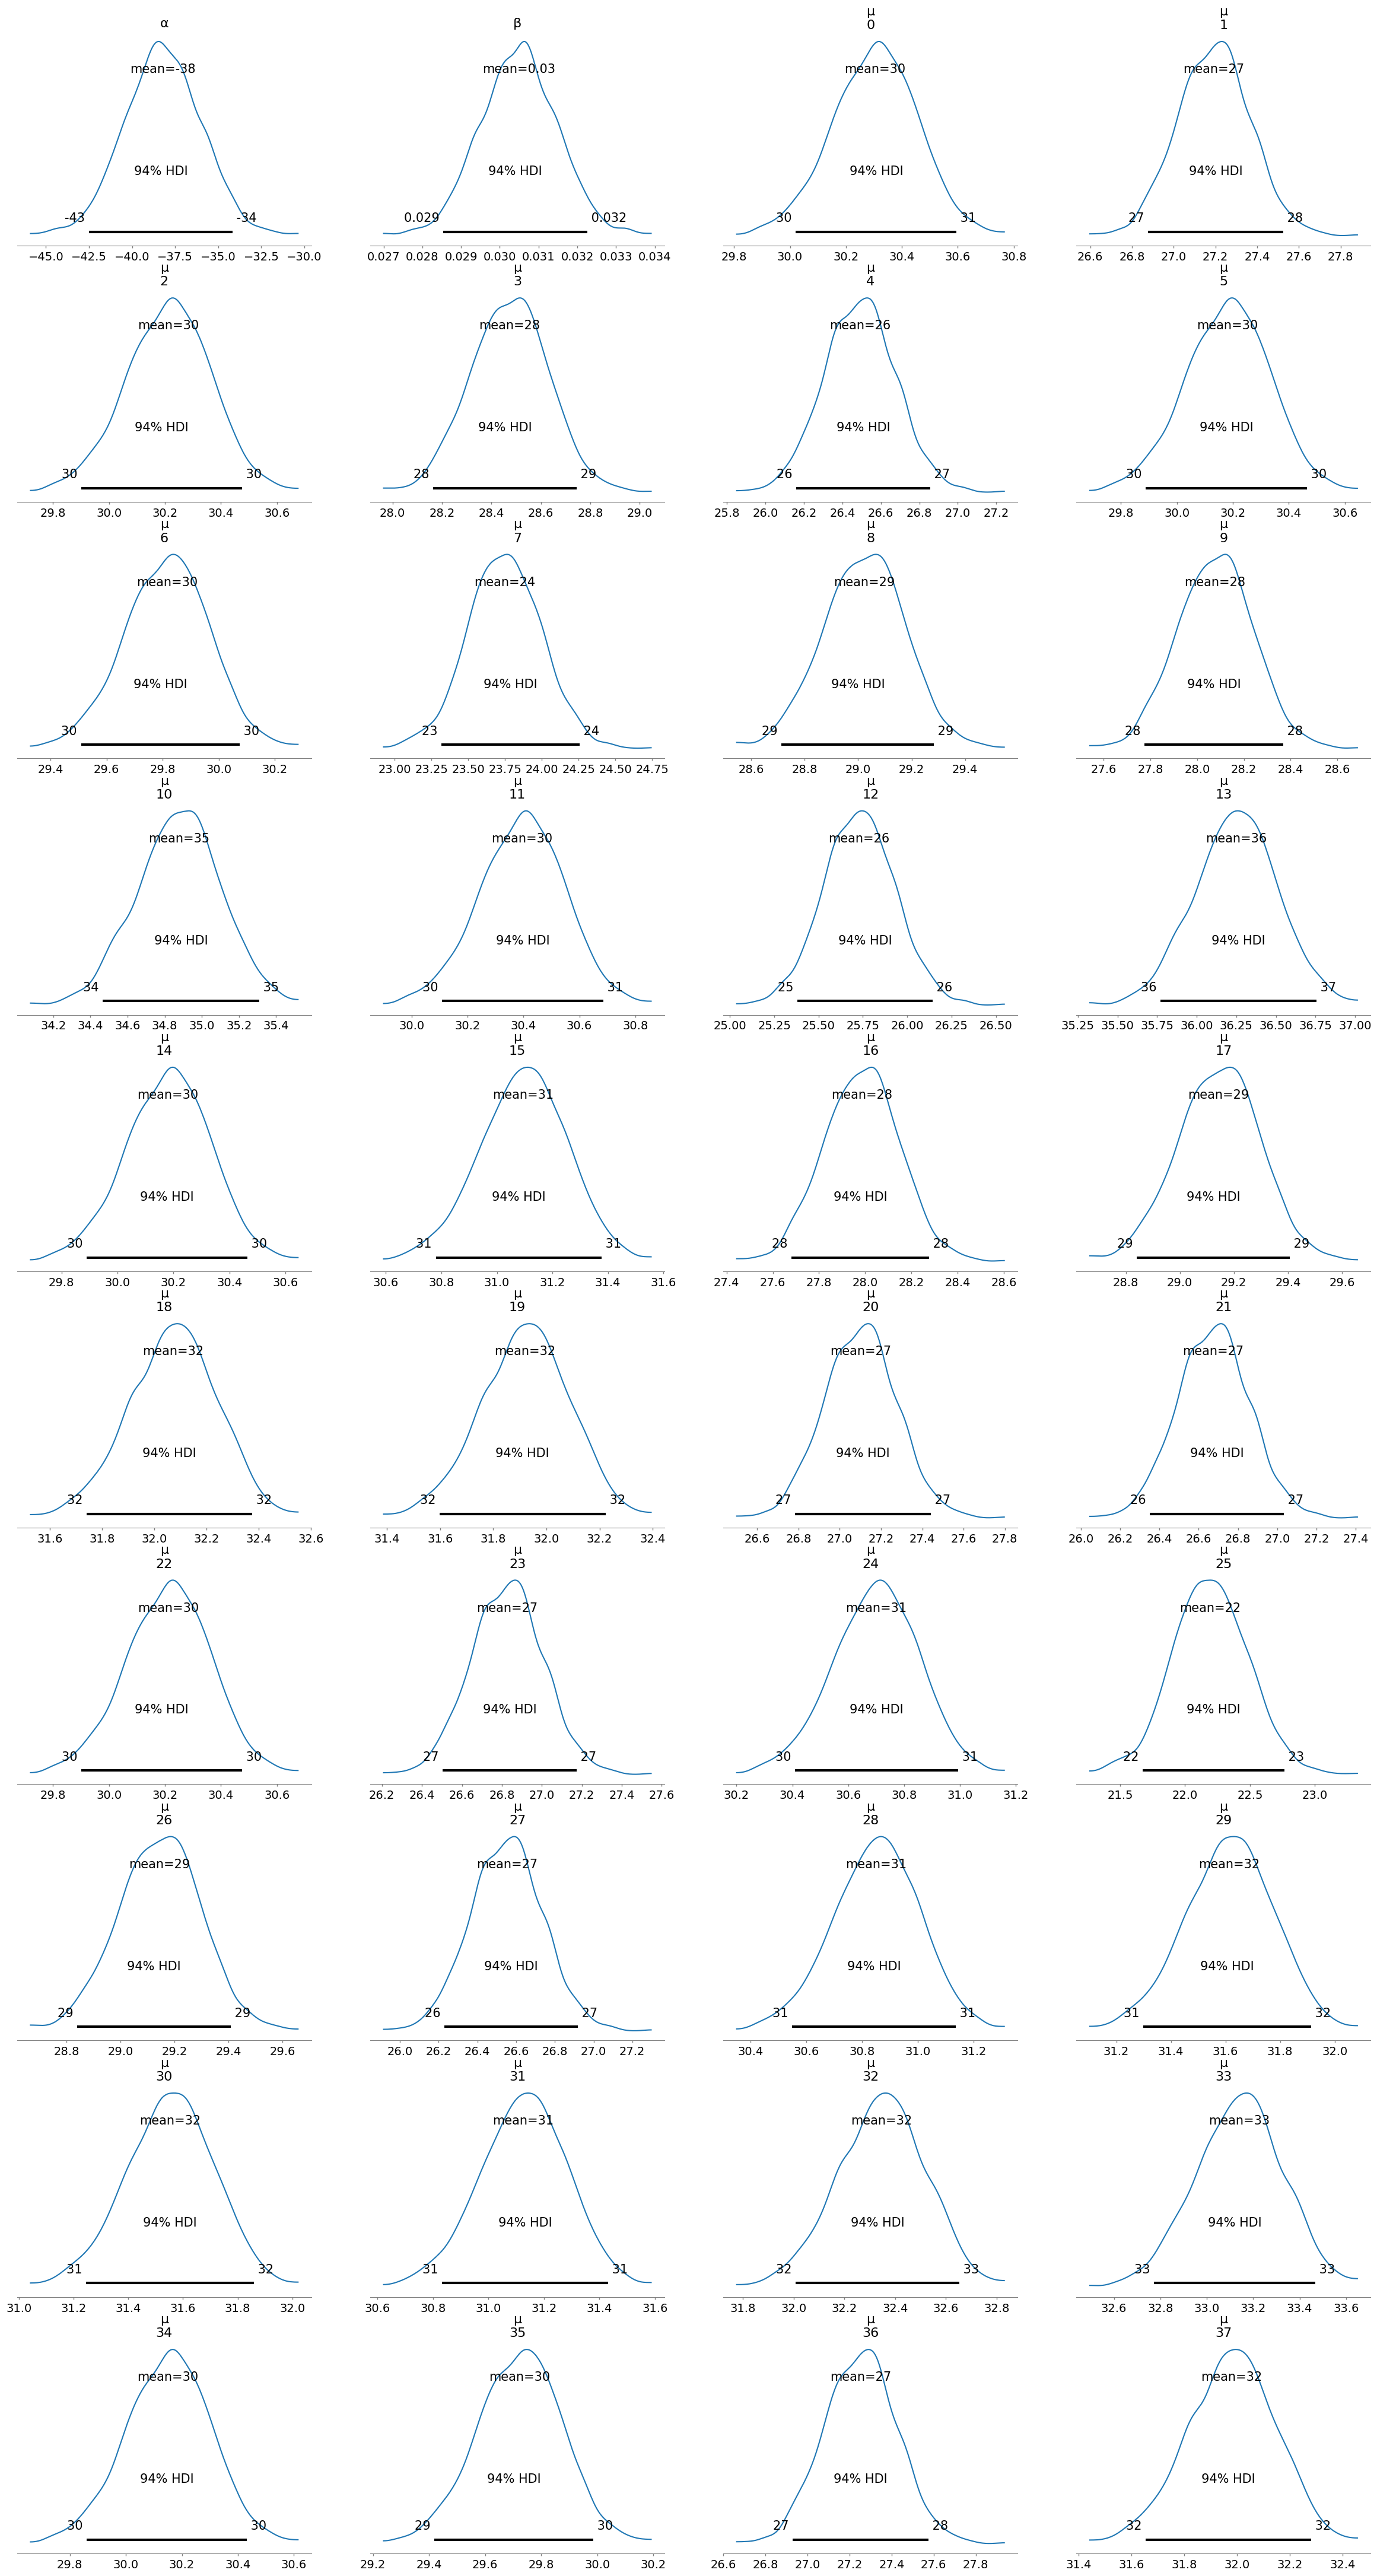

In [27]:
az.plot_posterior(idata_chess2)

In [28]:
# posterior predictive check
pm.sample_posterior_predictive(idata_chess2, model=model_chess2,  extend_inferencedata=True, progressbar=False)

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

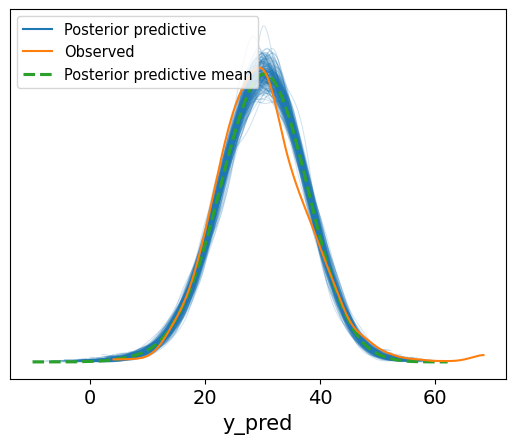

In [29]:
az.plot_ppc(idata_chess2, num_pp_samples=200, colors=['C0', 'C1', 'C2'])

The difference in the posterior checks is not substantial but I believe this one is still notably better than the previous one. It is more centered around the true values.

Text(0, 0.5, 'Percent of Games that End in a Draw')

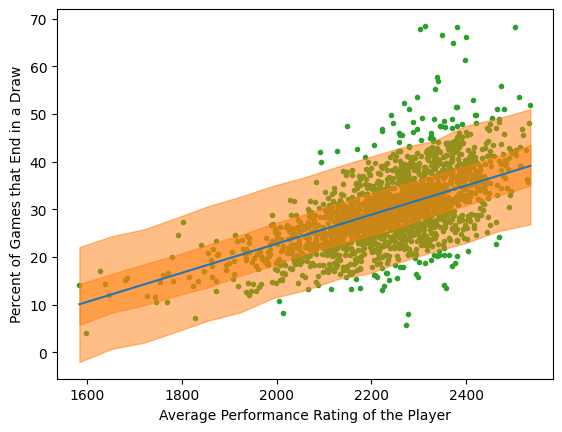

In [30]:
#ANSWER5 cont.

mean_line = idata_chess2.posterior["μ"].mean(("chain", "draw"))
ratings = np.random.normal(chess_data.perf_rating.values, 0.01)
idx = np.argsort(ratings)
x = np.linspace(ratings.min(), ratings.max(), 15)
y_pred_q = idata_chess2.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(ratings[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(chess_data.perf_rating, chess_data.perc_draw, "C2.", zorder=-3)
ax.plot(chess_data.perf_rating[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("Average Performance Rating of the Player")
ax.set_ylabel("Percent of Games that End in a Draw")

I like the generalized model. Maybe it didn't account for the quite a few outliers but overall captured the data pretty well.

# Conclusion

Overall I see pretty strong correlations between the Average Performance Rating of a Player and the Percent of Games That End in a Draw.

My generalized model ended up performing better than the standard linear regression model, as expected, by the posterior checks.

Logically speaking, I can see how this makes sense because once you get to a higher level in chess, there are fewer errors to capitalize on. As you use deeper and more advanced openings with lots of theory, it often results in a equal position for both sides.